# ROB 498: Robot Learning for Planning and Control
# Final Project: GPs for Bayesian Optimization

## Colab Setup

### Setup Code 

In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
import os
import sys

files = os.listdir()
expected_files = [ 'ROB498_hw3.ipynb', 'learning_state_dynamics.py', 'panda_pushing_env.py', 'visualizers.py',  'mppi.py', 'validation_data.npy']

# Verify that there are all the expected files in the directory
all_found = True
for expected_file in expected_files:
  if expected_file not in files:
    print(f'Required file {expected_file} not found!')
    all_found = False
if all_found:
  print('All required files are found :)')


import torch
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from numpngw import write_apng
from IPython.display import Image
from tqdm.notebook import tqdm
from learning_state_dynamics import collect_data_random
from learning_state_dynamics import process_data_single_step, SingleStepDynamicsDataset

All required files are found :)


## Simulation Environment Introduction

For our planar pushing setup, we will use PyBullet to simulate a panda robot that pushes a block on top of a table.
The pushing block is visualized in white. In green, we visualize the goal pose of the block.



In [9]:
from panda_pushing_env import PandaPushingEnv
from visualizers import GIFVisualizer, NotebookVisualizer

Run the following code block to visualize the robot pushing the block.

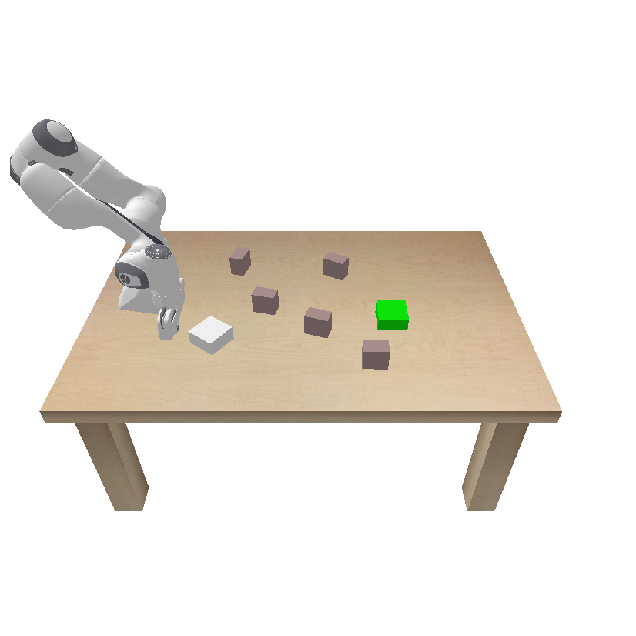

argv[0]=--opengl2
argv[0]=--opengl2


100%|██████████| 3/3 [00:03<00:00,  1.30s/it]


In [23]:
%matplotlib inline

# Create the visualizer
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# Initialize the simulation environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=True,  camera_heigh=800, camera_width=800)
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)

env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(3)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

plt.close(fig)

For speeding up the visualization, we will only visualize the pushing part of the robot motion. However, be aware of the full robot motion.

There is another option for visualization, which is to create a `.gif` file. The following cell shows an example of this. Note that here we set the rendering mode to just render the push motion for efficiency.

  0%|          | 0/10 [00:00<?, ?it/s]

argv[0]=--opengl2
Creating animated gif, please wait about 10 seconds


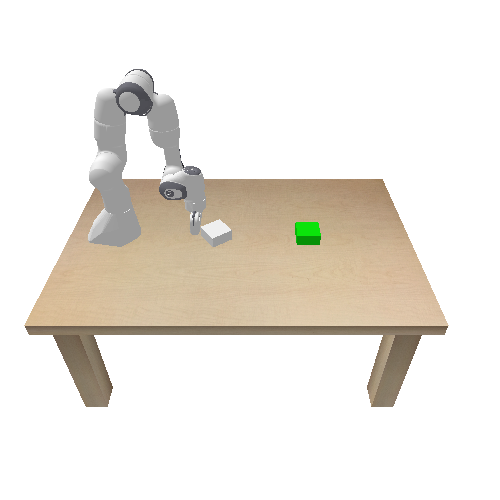

In [11]:
# Create the GIF visualizer
visualizer = GIFVisualizer()

# Initialize the simulation environment. This will only render push motions, omitting the robot reseting motions.
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False, camera_heigh=500, camera_width=500, render_every_n_steps=5)
env.reset()

# Perform a sequence of 3 random actions:
for i in tqdm(range(10)):
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        break

# Create and visualize the gif file.
Image(filename=visualizer.get_gif())



Rendering is useful for visualizing the implementation's performance and debugging. However, it consumes resources and takes time to produce. The following cell will perform 100 pushes without rendering. Compare the time with the previous rendering approaches. This should be an order of magnitude faster.

In [12]:
# Simulate pushing without rendering - this should take about 30s.
visualizer = None # No redering

env = PandaPushingEnv(visualizer=visualizer)
env.reset()

pbar =  tqdm(range(100)) # We will perform 100 pushes.

for i in pbar:
    action_i = env.action_space.sample()
    state, reward, done, info = env.step(action_i)
    if done:
        env.reset()


argv[0]=--opengl2


  0%|          | 0/100 [00:00<?, ?it/s]

### State Space and Action Space

For the planar pushing task, we have the following action and state spaces:

The image below illustrates the state space, which is the block planar location on top of the table. 
$$
\mathbf x = \begin{bmatrix} x & y & \theta\end{bmatrix}^\top\in \text{SE}(2)
$$
Note that the state contains only position elements, and not velocity terms. This is because we assume that the pushing task is *quasi-static*. This means that the pushing actions are slow enough that the velocity and inertia of the block are negligible. In other words, if the robot stops pushing, the block also stops.


![State Space](https://drive.google.com/uc?export=view&id=1iuHwUC_IVsrBbgbyiR8qXDV4OBmgKObU)

Note that the robot is centered at the origin. 


The following image show the robot action space. 

![Action Space](https://drive.google.com/uc?export=view&id=1sFyNOAj-RmNbwk_Ww8VxmmkCaW4LpVZj)

Each action $\mathbf u = \begin{bmatrix} p & \phi & \ell\end{bmatrix}^\top\in \mathbb R^3$ is composed by:
* $p \in [-1,1]$: pushing location along the lower block edge.
* $\phi \in [-\frac{\pi}{2},\frac{\pi}{2}]$ pushing angle.
* $\ell\in [0,1]$ pushing length as a fraction of the maximum pushing length. The maximum pushing length is is 0.1 m



### Gym Environments

Our planar pushing task has been wrapped into a `gym` environment. You can find more information about the gym environments [here](https://gymnasium.farama.org/api/env/).

As a gym enviroment, our pushing enviroment has the following useful methods:

* `step`: Given an action vector, it performs the action in the simulator and returns 
    1. `state`: The resulting state, i.e. $s_{t+1}$
    2. `reward`: Not used here (useful for Reinforcement Learning tasks).
    3. `done`: Boolean. In our case the simulation is done (`done=True`) if the robot has reached the goal location or if the block has left the bounds of the workspace.
    4. `info`: Dictionary containing additional data. Not used here.
Example:
```python
state, reward, done, info = env.step(action_i)
```
* `reset`: Resets the simulation to the initial state. It returns the inital state after reset.
Example:
```python
    state = env.reset()
```

Moreover, our pushing environment has the following attributes:
* `env.action_space`: Represents the action space, following the described parametrization above.
* `env.observation_space`: Represents the state space (block pose in $SE(2)$)
These are `gym.spaces` and therefore you can sample them using `.sample()`.
Example:
```python
action_i = env.action_space.sample()
```
This produces actions uniformly sampled from the action space.

You can find more info about gym spaces [here](https://gymnasium.farama.org/api/spaces/).



## TODO: Implement TS-GP stuff, CMA-ES, modify cost functions to account for more obstacles

Add imports as necessary, will use multistep residual dynamics model, retrain on HW3 if necessary

In [26]:
from learning_state_dynamics import *
from panda_pushing_env import *

pushing_residual_dynamics_model = ResidualDynamicsModel(3,3)
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_residual_dynamics_model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

### 4.1 - Obstacle-Free Pushing (15 points)
In this first part, we will consider the task of pushing an object to a goal pose with no obstacles on the table. We will use the following quadratic cost:

$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} (\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal})$$

with 
$$ Q = \begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 0.1
\end{bmatrix}$$
**TODO:**
* Implement `free_pushing_cost_function` in `learning_state_dynamics.py`.
  This function should compute the state cost for MPPI as defined above.  
* Complete the MPPI-based controller classs `PushingController` in `learning_state_dynamics.py`.
  You need to implement:
   * Tune MPPI controller hyperparameters in the `__init__` method.
   * Implement the `_compute_dynamics` method which should compute `next_state` from `state` and `action`.
   * Implement the `control` method which should return the `action` from a `state`. 
   
Read all docstrings carefully for details about the expected inputs, outputs and uses.

You should expect to see the robot pushing the block directly to the goal, typically finishing this task in fewer than 10 steps. 


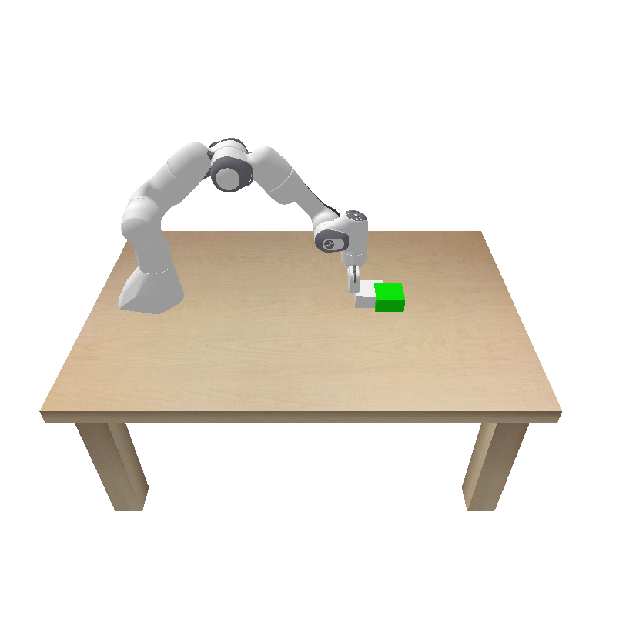

argv[0]=--opengl2


 20%|██        | 4/20 [00:09<00:38,  2.38s/it]

GOAL REACHED: True


In [24]:
# Control on an obstacle free environment
%matplotlib inline

fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)


env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_residual_dynamics_model, free_pushing_cost_function, num_samples=100, horizon=10)
env.reset()

state_0 = env.reset()
state = state_0

# num_steps_max = 100
num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_FREE
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
plt.close(fig)




### 4.2 - Pushing with Obstacles (15 points)
Now, we will repeat the task but adding an obstacle to the scene. The goal is to push the block to the goal while avoiding the obstacle.
You will have to first implement a basic collision detection algorithm. 

Then, you will have to use the collision detection inside the cost function to assign high cost to in-collision trajectories

#### 4.2.1 - Collision Detection Function (5 points)

The obstacle we are considering is a rectangle. At a given SE2 pose $[x, y, \theta]$ we can check collision by checking whether or not these two rectangles intersect. 

![Action Space](https://drive.google.com/uc?export=view&id=1yC2SxtbtmhInkYk-rzR2TAAYuD4JM-I0)

**TODO:**
* Implement `collision_detection` in `learning_state_dynamics.py`.
* The relevant parameters $(w, w_{obs} l_{obs}, x_{obs}, y_{obs})$ are already specified inside the function as `box_size`, `obstacle_dims`, and `obstacle_centre`. 


#### 4.2.2 - Cost Function for Obstacle Avoidance (10 points)

You should implement a new cost function to reach the goal while avoiding the obstacle. The cost should be
$$\text{Cost}(\mathbf x_1, ..., \mathbf x_T) = \sum^T_{t=1} \left((\mathbf x_t - \mathbf x_{goal})^T Q (\mathbf x_t - \mathbf x_{goal}) + 100 \texttt{in\_collision}(\mathbf x_t)\right)$$

With $Q$ defined as in the obstacle-free case, and `in_collision` is the binary output of the collision detection function you implemented above. This should add an additional state cost of 100 whenever a state is in collision.

**TODO:**

* Implement `obstacle_avoidance_pushing_cost_function` in `learning_state_dynamics.py`.

If implemented successfully, you should see the robot pushing the block around the obstacle to the goal. The robot should complete the task within the 20 steps, but may take 15-20 steps to do so. Even with a good dynamics model the robot may occasionally get the block stuck on the obstacle, but should complete the task successfully more often than not.

In [27]:
# Control on an obstacle free environment
%matplotlib inline
pushing_multistep_residual_dynamics_model = ResidualDynamicsModel(3,3)
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_multistep_residual_dynamics_model.load_state_dict(torch.load(model_path))
fig = plt.figure(figsize=(8,8))
hfig = display(fig, display_id=True)
visualizer = NotebookVisualizer(fig=fig, hfig=hfig)

# set up controller and environment
env = PandaPushingEnv(visualizer=visualizer, render_non_push_motions=False,  include_obstacle=True, camera_heigh=800, camera_width=800, render_every_n_steps=5)
controller = PushingController(env, pushing_multistep_residual_dynamics_model,
                               obstacle_avoidance_pushing_cost_function, num_samples=1000, horizon=20)
env.reset()
pushing_residual_dynamics_model = ResidualDynamicsModel(3,3)
model_path = os.path.join('pushing_multi_step_residual_dynamics_model.pt')
pushing_residual_dynamics_model.load_state_dict(torch.load(model_path))

state_0 = env.reset()
state = state_0

num_steps_max = 20

for i in tqdm(range(num_steps_max)):
    action = controller.control(state)
    state, reward, done, _ = env.step(action)
    if done:
        break

        
# Evaluate if goal is reached
end_state = env.get_state()
target_state = TARGET_POSE_OBSTACLES
goal_distance = np.linalg.norm(end_state[:2]-target_state[:2]) # evaluate only position, not orientation
goal_reached = goal_distance < BOX_SIZE

print(f'GOAL REACHED: {goal_reached}')
        
        
# Evaluate state
plt.close(fig)

<Figure size 800x800 with 0 Axes>

argv[0]=--opengl2


  0%|          | 0/20 [00:00<?, ?it/s]


TypeError: 'NoneType' object is not subscriptable

<Figure size 800x800 with 0 Axes>